## Author: Xiang (Albert) Li
## USC ID: 1892796881
## Github Userid: XiangLi1209
## Created Time: Feb 5th, 2023

### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import math
import sklearn.metrics
from tabulate import tabulate
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import copy

## 1. Combined Cycle Power Plant Data Set

### The dataset contains data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.

#### (a) Download the Combined Cycle Power Plant data1 from: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

In [2]:
pp=pd.read_excel('../data/Folds5x2_pp.xlsx') #This would only load the first sheet of the file, as required by hw2
pp.head() #Have a basic understanding of the dataset

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


#### (b) Exploring the data: 
#### i. How many rows are in this data set? How many columns? What do the rows and columns represent?

In [3]:
pp.shape
#From the return(9568,5), we can see that there are 9568 rows and 5 columns in the dataset
# For each row, there is represents an hourly average input point, as for each column, according to UCI ML Repository:
#AT: Average Temperature range 1.81°C and 37.11°C;
#V: Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg;
#AP: Ambient Pressure (AP) in the range 992.89-1033.30 milibar;
#RH: Relative Humidity in the range 25.56% to 100.16%;
#PE: Net hourly electrical energy output 420.26-495.76 MW. This is also the parameter that we need to predict

(9568, 5)

#### ii. Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.

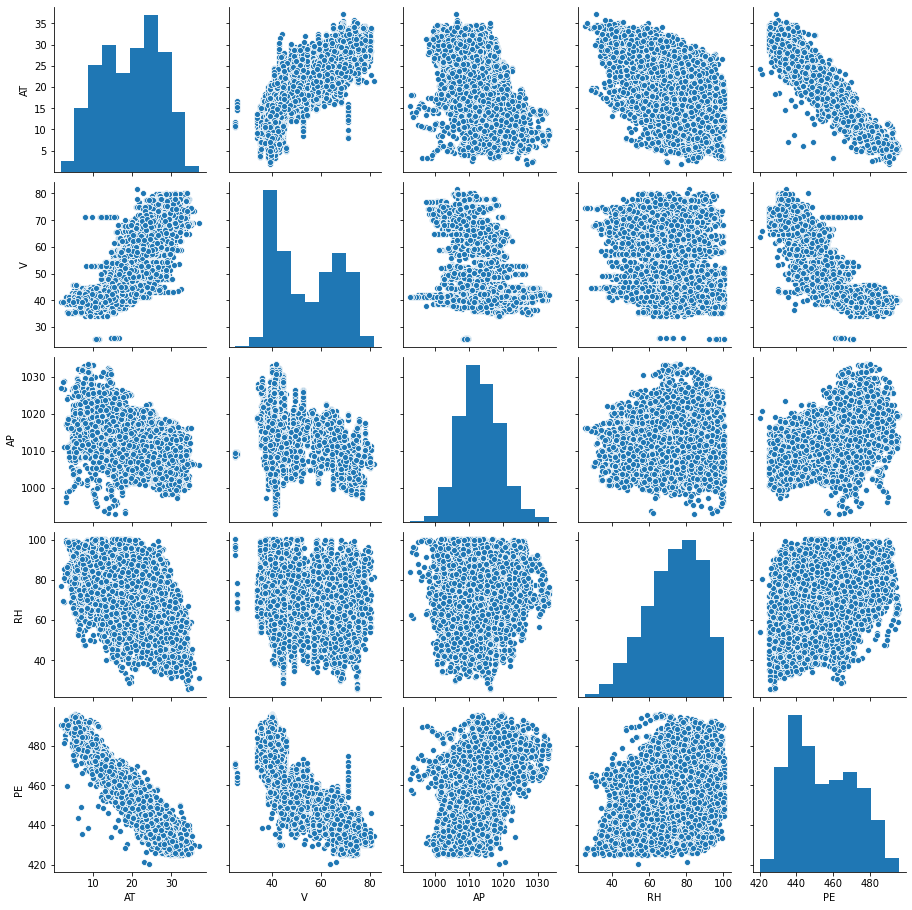

In [4]:
sns.pairplot(pp) 
# All values are numeric values. The distribution for V isn't as normal as other variables.
# In terms of relationship between variables and PE, we can see that AT has a clear 
# linear relationship with PE, whie V is more exponential. As for AP and RH, the relationship is less clear.

#### iii. What are the mean, the median, range,  first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [5]:
# Compute the mean, median, and range of each variable
mean = pp.mean()
median = pp.median()
rng = pp.max() - pp.min()

# Compute the quartiles and interquartile range of each variable
q1 = pp.quantile(0.25)
q3 = pp.quantile(0.75)
iqt = q3 - q1

# Make a table to summarize all statistic values
table = pd.concat([mean,median,rng,q1,q3,iqt],axis=1)
table.columns=['mean','median','rng','q1','q3','iqt']
table

,mean,median,rng,q1,q3,iqt
AT,19.651231,20.345,35.30,13.5100,25.72,12.2100
V,54.305804,52.080,56.20,41.7400,66.54,24.8000
AP,1013.259078,1012.940,40.41,1009.1000,1017.26,8.1600
RH,73.308978,74.975,74.60,63.3275,84.83,21.5025
PE,454.365009,451.550,75.50,439.7500,468.43,28.6800


#### (c) For each predictor,  fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [6]:
trymod = sm.OLS(pp['PE'],pp[['V']]).fit()
trymod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PE   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                          1.318e+05
Date:                Tue, 07 Feb 2023   Prob (F-statistic):                        0.00
Time:                        19:17:51   Log-Likelihood:                         -59245.
No. Observations:                9568   AIC:                                  1.185e+05
Df Residuals:                    9567   BIC:                                  1.185e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
V              7.8718      0.022    363.069      0.000       7.829       7.914
==============================================================================
Omnibus:                    66054.809   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              886.586
Skew:                          -0.148   Prob(JB):                    3.02e-193
Kurtosis:                       1.538   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

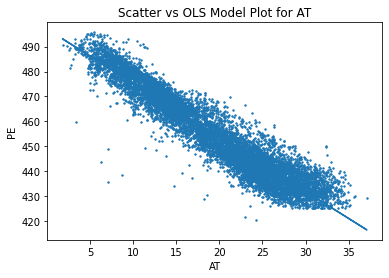

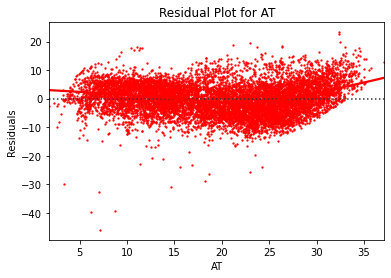

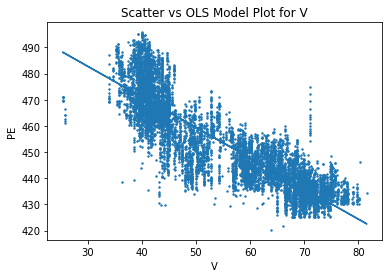

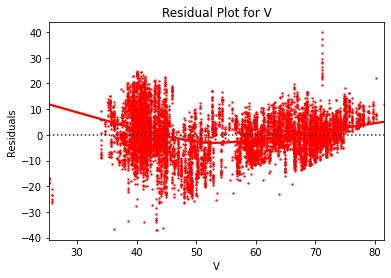

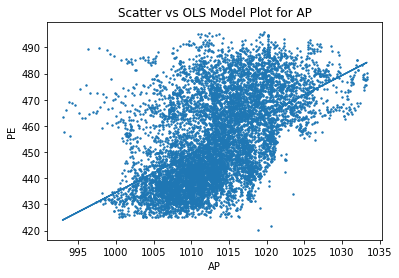

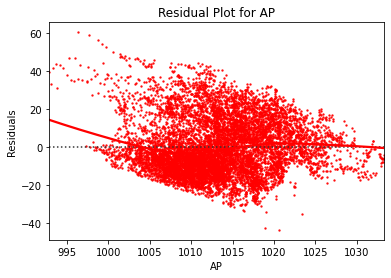

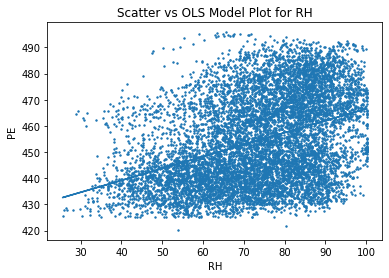

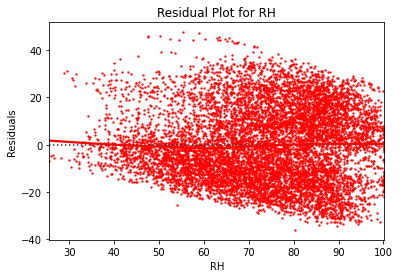

In [7]:
# Initialize the parameter
models = {}
var = pp.columns[:4]

# Fit a linear regression model for each variable within a for-loop
for column in var:
    X = pp[[column]]
    y = pp['PE']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    models[column] = model
    
    # Plot a simple scatter plot with the fitted model for each variable
    plt.scatter(pp[column], y, label=column,s=2)
    plt.plot(pp[column], model.predict(X))
    plt.xlabel(column)
    plt.ylabel("PE")
    plt.title("Scatter vs OLS Model Plot for " + column)
    plt.show()
    # Plot the residuals for exploratory purpose
    sns.residplot(pp[column], y, lowess=True,color='red',scatter_kws={'s':2})
    plt.xlabel(column)
    plt.ylabel("Residuals")
    plt.title("Residual Plot for " + column)
    plt.show()
    
# AT vs PE has a clear linear relationship and is captured by the OLS model and the residual plot looks normal
# V vs PE has a more exponential relationship and is partially captured by the OLS model with possible extreme 
# values at V ~ 70, while the residul plot, and is a rough fan shape, suggesting minor heteroscedasticity issue
# AP vs PE has a somewhat linear relationship and is captured by the OLS model, and the residual plot looks normal
# RH vs PE has little relationship from the scatter plot, but the residual plot looks normal



In [8]:
# Print the summary of each model
for column, model in models.items():
    print("Variable:", column)
    print(model.summary())
# These four summary reports suggest that all four variables are statistically significant with p is approaximately 0
# But the R-squared value for both AP & RH are quite low (lower than 0.3), which is consistant with the scatterplot

Variable: AT
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:55   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3177

#### (d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0$ :  $\beta_j$= 0?

In [9]:
# Fit a multiple linear regression model
X_all = pp[pp.columns[:-1]]
X_all = sm.add_constant(X_all)
y = pp['PE']
mod_all = sm.OLS(y, X_all).fit()
mod_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:55   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.000     435.500     473.718
AT            -1.9775      0.015   -129.342      0.000      -2.007      -1.948
V             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
AP             0.0621      0.009      6.564      0.000       0.044       0.081
RH            -0.1581      0.004    -37.918      0.000      -0.166      -0.150
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### (e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coe cients from 1c on the x-axis, and the multiple regression coe cients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coe cient in a simple linear regression model is shown on the x-axis, and its coe cient estimate in the multiple linear regression model is shown on the y-axis.

The p-values are still very small, however, the R-squared = 1 (perfect fit) for this additive model, which is a dangerous sign for possible overfitting (need predictions on test dataset to tell).

#### (f)Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X,  fit a model of the $form^2$
\begin{align*}
    Y &= \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + e
\end{align*}


In [10]:
# Trial for just AT
polynomial_features= PolynomialFeatures(degree=3)
X_AT3 = polynomial_features.fit_transform(pp[['AT']])
X_AT3 = sm.add_constant(X_AT3)
y = pp['PE']
model_AT3 = sm.OLS(y, X_AT3).fit()
model_AT3.summary()

# Different value from the summary table below

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:55   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.000     491.409     494.047
x1            -0.6103      0.124     -4.941      0.000      -0.852      -0.368
x2            -0.1251      0.007    -18.199      0.000      -0.139      -0.112
x3             0.0027      0.000     22.594      0.000       0.002       0.003
==============================================================================
Omnibus:                      648.041   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2767.059
Skew:                          -0.191   Prob(JB):                         0.00
Kurtosis:                       5.607   Cond. No.                     1.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# Initialize the parameter
models_3 = {}
var = pp.columns[:4]
polynomial_features = PolynomialFeatures(degree=3)
y = pp['PE']

# Fit a linear regression model for each variable within a for-loop
for column in var:
    X3 = polynomial_features.fit_transform(pp[[column]])
    X3 = sm.add_constant(X3)
    model_3 = sm.OLS(y, X3).fit()
    models_3[column] = model_3

for column, model in models_3.items():
    print('The summary for',column,'model is: ',model_3.summary())

The summary for AT model is:                              OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:55   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135 

#### (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [12]:
#Create a list of pairwise interaction terms and add that into the column
interactions = list(itertools.combinations(var,2))
pp_g = copy.deepcopy(pp)
for i in interactions:
    name = i[0] + '&' + i[1]
    pp_g[name] = pp_g[i[0]]*pp_g[i[1]]
    
var_g = [col for col in pp_g.columns if col!='PE']
print(var_g)
x_g = sm.add_constant(pp_g[var_g]) #Adding the constant term
mod_g = sm.OLS(pp_g['PE'],x_g).fit()

print(mod_g.summary())
# From the summary table, we can see that all interaction terms have statistically significant small p-vale except
# the one of V&RH = 0.086. Thus, there are evidence of association of interactgions of predictors with response.

['AT', 'V', 'AP', 'RH', 'AT&V', 'AT&AP', 'AT&RH', 'V&AP', 'V&RH', 'AP&RH']
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:55   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### (h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [13]:
# train on 70% of the data with all predictors
pp_h = copy.deepcopy(pp)
X_h = pp_h.drop('PE',axis=1)
X_h = sm.add_constant(X_h)
y = pp_h['PE']
x_train_h1,x_test_h1,y_train_h1,y_test_h1 = train_test_split(X_h,y,test_size = 0.3,random_state = 40)
mod_h1=sm.OLS(y_train_h1,x_train_h1).fit() 
print(mod_h1.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.209e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:56   Log-Likelihood:                -19604.
No. Observations:                6697   AIC:                         3.922e+04
Df Residuals:                    6692   BIC:                         3.925e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        441.9597     11.502     38.426      0.0

In [14]:
# all possible interaction terms and quadratic nonlinearities
pp_h_2 = copy.deepcopy(pp)

# Adding interaction terms like part g
interactions = list(itertools.combinations(var,2))
for i in interactions:
    name = i[0] + '&' + i[1]
    pp_h_2[name] = pp_h_2[i[0]]*pp_h_2[i[1]]

# Adding quadratic terms
for col in var:
    pp_h_2[col + '_sq'] = np.power(pp_h_2[col],2)

X_h2 = pp_h_2.drop('PE',axis=1)
y=pp_h['PE']
x_train_h2,x_test_h2,y_train_h2,y_test_h2 = train_test_split(X_h2,y,test_size = 0.3,random_state = 40)
x_train_h2 = sm.add_constant(x_train_h2)
mod_h2 = sm.OLS(y_train_h2,x_train_h2).fit()
print(mod_h2.summary())
# From the summary table's p-val, we can see that V, V&AP, V&RH, V_sq are very large, with the 
# AP&RH on the boarderline (0.057). Thus, we can try mod_h3 without these predictors. However, since the AT&V is 
# significant, we should still keep the V predictor.

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7291.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:56   Log-Likelihood:                -19147.
No. Observations:                6697   AIC:                         3.832e+04
Df Residuals:                    6682   BIC:                         3.843e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5954.2606   1432.135     -4.158      0.0

In [15]:
pp_h3 = copy.deepcopy(pp_h_2)
pp_h3.columns

pp_h3 = pp_h3.drop(columns=['V_sq','V&AP','V&RH','AP&RH'])
pp_h3.head()
X_h3 = pp_h3.drop('PE',axis = 1)
y = pp_h3['PE']
x_train_h3,x_test_h3,y_train_h3,y_test_h3 = train_test_split(X_h3,y,test_size = 0.3,random_state = 40)
x_train_h3 = sm.add_constant(x_train_h3)
mod_h3 = sm.OLS(y_train_h3,x_train_h3).fit()
print(mod_h3.summary())
# From this new summary table, we can see that all predictors are statistically significant.

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:17:56   Log-Likelihood:                -19154.
No. Observations:                6697   AIC:                         3.833e+04
Df Residuals:                    6686   BIC:                         3.841e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3867.4119   1301.379     -2.972      0.0

In [16]:
# Make predictions based on the mod_h and mod_h3 based on their corresponding test dataset
x_test_h1 = sm.add_constant(x_test_h1)
x_test_h3 = sm.add_constant(x_test_h3)

y_h1 = mod_h1.predict(x_test_h1)
y_h3 = mod_h3.predict(x_test_h3)

mse_h = mean_squared_error(y_test_h1, y_h1)
mse_h3 = mean_squared_error(y_test_h3, y_h3)

print(mse_h,mse_h3)
# From the MSE value, we can see that mod_h3, which includes all predictors, statistically significant interactions 
# and quadratic terms is better than the mod_h1, which only have all predictors.

21.60588240522413 18.860772199276553


#### (i) KNN Regression:  Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k $k \in \{1,2,...100\}$that gives you the best  fit. Plot the train and test errors in terms of 1/k.

In [17]:
k_list = [i for i in range(1,101,1)]
# On the raw features using the same train and test data splitted in the h and on normalized data in the same for loop
test_error_raw = []
train_error_raw = []
train_error_norm = []
test_error_norm = []

# Normalized data
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_h1)
x_test_norm = scaler.transform(x_test_h1)

for k in k_list:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train_h1,y_train_h1)
    train_pred_raw = knn.predict(x_train_h1)
    test_pred_raw = knn.predict(x_test_h1)
    test_error_raw.append(mean_squared_error(y_test_h1, test_pred_raw))
    train_error_raw.append(mean_squared_error(y_train_h1, train_pred_raw))
    # for noramlized data
    knn.fit(x_train_norm,y_train_h1)
    train_pred_norm = knn.predict(x_train_norm)
    test_pred_norm = knn.predict(x_test_norm)
    test_error_norm.append(mean_squared_error(y_test_h1, test_pred_norm))
    train_error_norm.append(mean_squared_error(y_train_h1, train_pred_norm))

In [18]:
print(min(test_error_norm),
min(test_error_raw))

best_k_norm = k_list[test_error_norm.index(min(test_error_norm))]
best_k_raw = k_list[test_error_raw.index(min(test_error_raw))]
print('best k for norm dataset is:',best_k_norm, 
      'best k for raw dataset is:',best_k_raw)

15.045765663096484 16.739065959402456
best k for norm dataset is: 4 best k for raw dataset is: 6


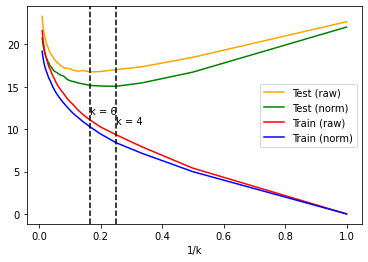

In [19]:
# make the 1/k v.s train & test error for both raw & normalized features plot
k_inv = [1/i for i in range(1,101,1)]
plt.plot(k_inv, test_error_raw, label = 'Test (raw)',color = 'orange')
plt.plot(k_inv, test_error_norm, label = 'Test (norm)',color = 'green')
plt.plot(k_inv, train_error_raw, label='Train (raw)',color = 'red')
plt.plot(k_inv, train_error_norm, label='Train (norm)',color = 'blue')
plt.xlabel('1/k')
plt.legend()
plt.axvline(x=1/best_k_norm, color='black', linestyle='--')
plt.text(1/best_k_norm, 0.7*np.min(test_error_norm), 'k = {}'.format(best_k_norm), rotation=0)
plt.axvline(x=1/best_k_raw, color='black', linestyle='--')
plt.text(1/best_k_raw, 0.7*np.min(test_error_raw), 'k = {}'.format(best_k_raw), rotation=0)
plt.show()

# From the plot, we can see that the optimal k for based on the raw dataset's test error is 6 with 16.739065959402456; 
# and it's 4 for normalized data with error 15.045765663096484.

#### (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

# One of the lowest error I achieved with linear regression is 18.860772199276553, while it's 15.045765663096484 for KNN models. Thus, it is safe to say that KNN with normalized dataset has the smallest test error.


## Q2. ISLR:2.4.1
### For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

### (a) the sample size n is extremly large, and the number of predictors p is small.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

### (c) The relationship between the predictors and response is highly non-linear.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

## Q3. ISLR: 2.4.7

### The table below provides a training data set containing six observations, three predictors, and one qualitative response variable. Suppose we wish to use this data set to make a prediction for Y when X1=X2=X3=0 using K-nearest neighbors

In [20]:
data = pd.DataFrame({'X1': [0, 2, 0, 0, -1, 1],
                     'X2': [3, 0, 1, 1, 0, 1],
                     'X3': [0, 0, 3, 2, 1, 1],
                     'Y': ['Red', 'Red', 'Red', 'Green', 'Green', 'Red']})
print(data)

   X1  X2  X3      Y
0   0   3   0    Red
1   2   0   0    Red
2   0   1   3    Red
3   0   1   2  Green
4  -1   0   1  Green
5   1   1   1    Red


### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

### (b) What is our prediction with K = 1? Why?

### (c) What is our prediction with K = 3? Why?

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

## Author: Xiang (Albert) Li
## USC ID: 1892796881
## Github Userid: XiangLi1209
## Created Time: Feb 5th, 2023

### Import packages

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import math
import sklearn.metrics
from tabulate import tabulate
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import copy

## 1. Combined Cycle Power Plant Data Set

### The dataset contains data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.

#### (a) Download the Combined Cycle Power Plant data1 from: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

In [22]:
pp=pd.read_excel('../data/Folds5x2_pp.xlsx') #This would only load the first sheet of the file, as required by hw2
pp.head() #Have a basic understanding of the dataset

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


#### (b) Exploring the data: 
#### i. How many rows are in this data set? How many columns? What do the rows and columns represent?

In [23]:
pp.shape
#From the return(9568,5), we can see that there are 9568 rows and 5 columns in the dataset
# For each row, there is represents an hourly average input point, as for each column, according to UCI ML Repository:
#AT: Average Temperature range 1.81°C and 37.11°C;
#V: Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg;
#AP: Ambient Pressure (AP) in the range 992.89-1033.30 milibar;
#RH: Relative Humidity in the range 25.56% to 100.16%;
#PE: Net hourly electrical energy output 420.26-495.76 MW. This is also the parameter that we need to predict

(9568, 5)

#### ii. Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.

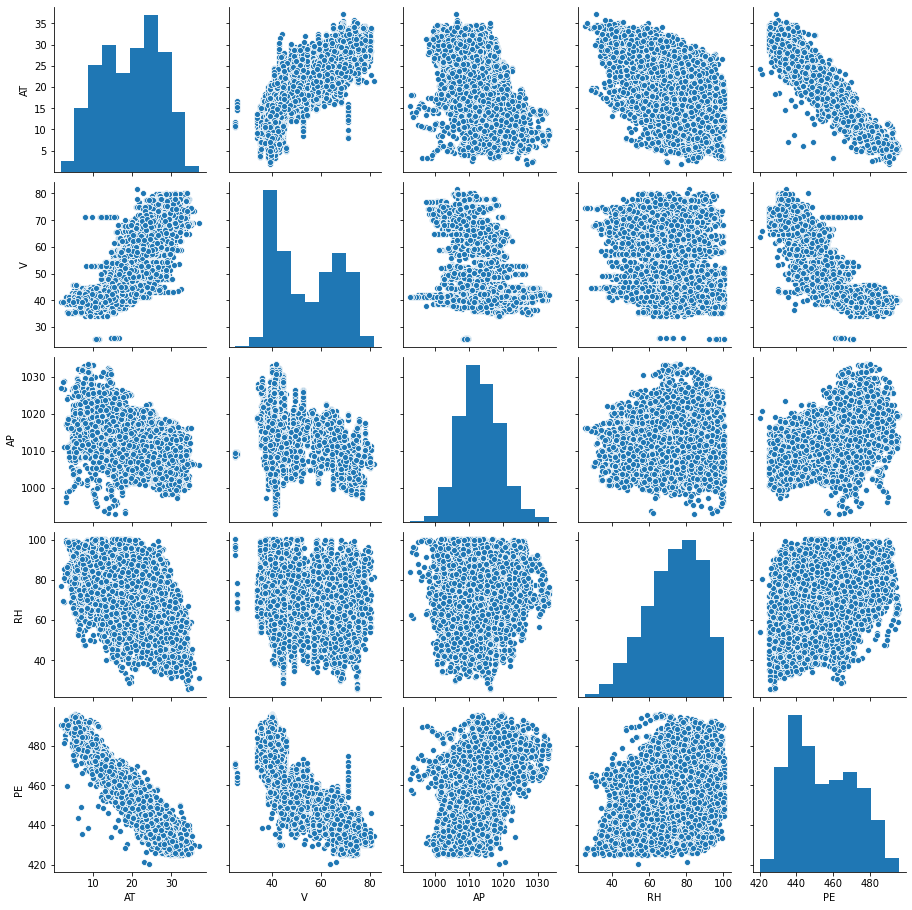

In [24]:
sns.pairplot(pp) 
# All values are numeric values. The distribution for V isn't as normal as other variables.
# In terms of relationship between variables and PE, we can see that AT has a clear 
# linear relationship with PE, whie V is more exponential. As for AP and RH, the relationship is less clear.

#### iii. What are the mean, the median, range,  first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [25]:
# Compute the mean, median, and range of each variable
mean = pp.mean()
median = pp.median()
rng = pp.max() - pp.min()

# Compute the quartiles and interquartile range of each variable
q1 = pp.quantile(0.25)
q3 = pp.quantile(0.75)
iqt = q3 - q1

# Make a table to summarize all statistic values
table = pd.concat([mean,median,rng,q1,q3,iqt],axis=1)
table.columns=['mean','median','rng','q1','q3','iqt']
table

,mean,median,rng,q1,q3,iqt
AT,19.651231,20.345,35.30,13.5100,25.72,12.2100
V,54.305804,52.080,56.20,41.7400,66.54,24.8000
AP,1013.259078,1012.940,40.41,1009.1000,1017.26,8.1600
RH,73.308978,74.975,74.60,63.3275,84.83,21.5025
PE,454.365009,451.550,75.50,439.7500,468.43,28.6800


#### (c) For each predictor,  fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [26]:
trymod = sm.OLS(pp['PE'],pp[['V']]).fit()
trymod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PE   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                          1.318e+05
Date:                Tue, 07 Feb 2023   Prob (F-statistic):                        0.00
Time:                        19:18:23   Log-Likelihood:                         -59245.
No. Observations:                9568   AIC:                                  1.185e+05
Df Residuals:                    9567   BIC:                                  1.185e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
V              7.8718      0.022    363.069      0.000       7.829       7.914
==============================================================================
Omnibus:                    66054.809   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              886.586
Skew:                          -0.148   Prob(JB):                    3.02e-193
Kurtosis:                       1.538   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Print the summary of each model
for column, model in models.items():
    print("Variable:", column)
    print(model.summary())
# These four summary reports suggest that all four variables are statistically significant with p is approaximately 0
# But the R-squared value for both AP & RH are quite low (lower than 0.3), which is consistant with the scatterplot

Variable: AT
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:18:23   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3177

#### (d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0$ :  $\beta_j$= 0?

In [28]:
# Fit a multiple linear regression model
X_all = pp[pp.columns[:-1]]
X_all = sm.add_constant(X_all)
y = pp['PE']
mod_all = sm.OLS(y, X_all).fit()
mod_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:18:23   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.000     435.500     473.718
AT            -1.9775      0.015   -129.342      0.000      -2.007      -1.948
V             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
AP             0.0621      0.009      6.564      0.000       0.044       0.081
RH            -0.1581      0.004    -37.918      0.000      -0.166      -0.150
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### (e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coe cients from 1c on the x-axis, and the multiple regression coe cients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coe cient in a simple linear regression model is shown on the x-axis, and its coe cient estimate in the multiple linear regression model is shown on the y-axis.

The p-values are still very small, however, the R-squared = 1 (perfect fit) for this additive model, which is a dangerous sign for possible overfitting (need predictions on test dataset to tell).

#### (f)Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X,  fit a model of the $form^2$
\begin{align*}
    Y &= \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + e
\end{align*}


In [29]:
# Trial for just AT
polynomial_features= PolynomialFeatures(degree=3)
X_AT3 = polynomial_features.fit_transform(pp[['AT']])
X_AT3 = sm.add_constant(X_AT3)
y = pp['PE']
model_AT3 = sm.OLS(y, X_AT3).fit()
model_AT3.summary()

# Different value from the summary table below

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:18:23   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.000     491.409     494.047
x1            -0.6103      0.124     -4.941      0.000      -0.852      -0.368
x2            -0.1251      0.007    -18.199      0.000      -0.139      -0.112
x3             0.0027      0.000     22.594      0.000       0.002       0.003
==============================================================================
Omnibus:                      648.041   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2767.059
Skew:                          -0.191   Prob(JB):                         0.00
Kurtosis:                       5.607   Cond. No.                     1.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# Initialize the parameter
models_3 = {}
var = pp.columns[:4]
polynomial_features = PolynomialFeatures(degree=3)
y = pp['PE']

# Fit a linear regression model for each variable within a for-loop
for column in var:
    X3 = polynomial_features.fit_transform(pp[[column]])
    X3 = sm.add_constant(X3)
    model_3 = sm.OLS(y, X3).fit()
    models_3[column] = model_3

for column, model in models_3.items():
    print('The summary for',column,'model is: ',model_3.summary())

The summary for AT model is:                              OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:18:23   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135 

#### (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [31]:
#Create a list of pairwise interaction terms and add that into the column
interactions = list(itertools.combinations(var,2))
pp_g = copy.deepcopy(pp)
for i in interactions:
    name = i[0] + '&' + i[1]
    pp_g[name] = pp_g[i[0]]*pp_g[i[1]]
    
var_g = [col for col in pp_g.columns if col!='PE']
print(var_g)
x_g = sm.add_constant(pp_g[var_g]) #Adding the constant term
mod_g = sm.OLS(pp_g['PE'],x_g).fit()

print(mod_g.summary())
# From the summary table, we can see that all interaction terms have statistically significant small p-vale except
# the one of V&RH = 0.086. Thus, there are evidence of association of interactgions of predictors with response.

['AT', 'V', 'AP', 'RH', 'AT&V', 'AT&AP', 'AT&RH', 'V&AP', 'V&RH', 'AP&RH']
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:18:23   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### (h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [32]:
# train on 70% of the data with all predictors
pp_h = copy.deepcopy(pp)
X_h = pp_h.drop('PE',axis=1)
X_h = sm.add_constant(X_h)
y = pp_h['PE']
x_train_h1,x_test_h1,y_train_h1,y_test_h1 = train_test_split(X_h,y,test_size = 0.3,random_state = 40)
mod_h1=sm.OLS(y_train_h1,x_train_h1).fit() 
print(mod_h1.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.209e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:18:23   Log-Likelihood:                -19604.
No. Observations:                6697   AIC:                         3.922e+04
Df Residuals:                    6692   BIC:                         3.925e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        441.9597     11.502     38.426      0.0

In [33]:
# all possible interaction terms and quadratic nonlinearities
pp_h_2 = copy.deepcopy(pp)

# Adding interaction terms like part g
interactions = list(itertools.combinations(var,2))
for i in interactions:
    name = i[0] + '&' + i[1]
    pp_h_2[name] = pp_h_2[i[0]]*pp_h_2[i[1]]

# Adding quadratic terms
for col in var:
    pp_h_2[col + '_sq'] = np.power(pp_h_2[col],2)

X_h2 = pp_h_2.drop('PE',axis=1)
y=pp_h['PE']
x_train_h2,x_test_h2,y_train_h2,y_test_h2 = train_test_split(X_h2,y,test_size = 0.3,random_state = 40)
x_train_h2 = sm.add_constant(x_train_h2)
mod_h2 = sm.OLS(y_train_h2,x_train_h2).fit()
print(mod_h2.summary())
# From the summary table's p-val, we can see that V, V&AP, V&RH, V_sq are very large, with the 
# AP&RH on the boarderline (0.057). Thus, we can try mod_h3 without these predictors. However, since the AT&V is 
# significant, we should still keep the V predictor.

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7291.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:18:23   Log-Likelihood:                -19147.
No. Observations:                6697   AIC:                         3.832e+04
Df Residuals:                    6682   BIC:                         3.843e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5954.2606   1432.135     -4.158      0.0

In [34]:
pp_h3 = copy.deepcopy(pp_h_2)
pp_h3.columns

pp_h3 = pp_h3.drop(columns=['V_sq','V&AP','V&RH','AP&RH'])
pp_h3.head()
X_h3 = pp_h3.drop('PE',axis = 1)
y = pp_h3['PE']
x_train_h3,x_test_h3,y_train_h3,y_test_h3 = train_test_split(X_h3,y,test_size = 0.3,random_state = 40)
x_train_h3 = sm.add_constant(x_train_h3)
mod_h3 = sm.OLS(y_train_h3,x_train_h3).fit()
print(mod_h3.summary())
# From this new summary table, we can see that all predictors are statistically significant.

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:18:23   Log-Likelihood:                -19154.
No. Observations:                6697   AIC:                         3.833e+04
Df Residuals:                    6686   BIC:                         3.841e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3867.4119   1301.379     -2.972      0.0

In [35]:
# Make predictions based on the mod_h and mod_h3 based on their corresponding test dataset
x_test_h1 = sm.add_constant(x_test_h1)
x_test_h3 = sm.add_constant(x_test_h3)

y_h1 = mod_h1.predict(x_test_h1)
y_h3 = mod_h3.predict(x_test_h3)

mse_h = mean_squared_error(y_test_h1, y_h1)
mse_h3 = mean_squared_error(y_test_h3, y_h3)

print(mse_h,mse_h3)
# From the MSE value, we can see that mod_h3, which includes all predictors, statistically significant interactions 
# and quadratic terms is better than the mod_h1, which only have all predictors.

21.60588240522413 18.860772199276553


#### (i) KNN Regression:  Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k $k \in \{1,2,...100\}$that gives you the best  fit. Plot the train and test errors in terms of 1/k.

In [36]:
k_list = [i for i in range(1,101,1)]
# On the raw features using the same train and test data splitted in the h and on normalized data in the same for loop
test_error_raw = []
train_error_raw = []
train_error_norm = []
test_error_norm = []

# Normalized data
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_h1)
x_test_norm = scaler.transform(x_test_h1)

for k in k_list:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train_h1,y_train_h1)
    train_pred_raw = knn.predict(x_train_h1)
    test_pred_raw = knn.predict(x_test_h1)
    test_error_raw.append(mean_squared_error(y_test_h1, test_pred_raw))
    train_error_raw.append(mean_squared_error(y_train_h1, train_pred_raw))
    # for noramlized data
    knn.fit(x_train_norm,y_train_h1)
    train_pred_norm = knn.predict(x_train_norm)
    test_pred_norm = knn.predict(x_test_norm)
    test_error_norm.append(mean_squared_error(y_test_h1, test_pred_norm))
    train_error_norm.append(mean_squared_error(y_train_h1, train_pred_norm))

In [37]:
print(min(test_error_norm),
min(test_error_raw))

best_k_norm = k_list[test_error_norm.index(min(test_error_norm))]
best_k_raw = k_list[test_error_raw.index(min(test_error_raw))]
print('best k for norm dataset is:',best_k_norm, 
      'best k for raw dataset is:',best_k_raw)

15.045765663096484 16.739065959402456
best k for norm dataset is: 4 best k for raw dataset is: 6


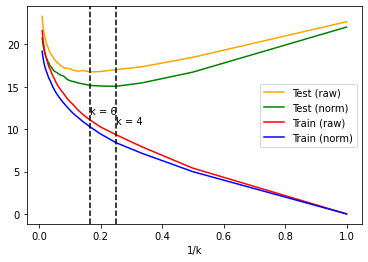

In [38]:
# make the 1/k v.s train & test error for both raw & normalized features plot
k_inv = [1/i for i in range(1,101,1)]
plt.plot(k_inv, test_error_raw, label = 'Test (raw)',color = 'orange')
plt.plot(k_inv, test_error_norm, label = 'Test (norm)',color = 'green')
plt.plot(k_inv, train_error_raw, label='Train (raw)',color = 'red')
plt.plot(k_inv, train_error_norm, label='Train (norm)',color = 'blue')
plt.xlabel('1/k')
plt.legend()
plt.axvline(x=1/best_k_norm, color='black', linestyle='--')
plt.text(1/best_k_norm, 0.7*np.min(test_error_norm), 'k = {}'.format(best_k_norm), rotation=0)
plt.axvline(x=1/best_k_raw, color='black', linestyle='--')
plt.text(1/best_k_raw, 0.7*np.min(test_error_raw), 'k = {}'.format(best_k_raw), rotation=0)
plt.show()

# From the plot, we can see that the optimal k for based on the raw dataset's test error is 6 with 16.739065959402456; 
# and it's 4 for normalized data with error 15.045765663096484.

#### (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

# One of the lowest error I achieved with linear regression is 18.860772199276553, while it's 15.045765663096484 for KNN models. Thus, it is safe to say that KNN with normalized dataset has the smallest test error.


## Q2. ISLR:2.4.1
### For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

### (a) the sample size n is extremly large, and the number of predictors p is small.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

### (c) The relationship between the predictors and response is highly non-linear.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

## Q3. ISLR: 2.4.7

### The table below provides a training data set containing six observations, three predictors, and one qualitative response variable. Suppose we wish to use this data set to make a prediction for Y when X1=X2=X3=0 using K-nearest neighbors

In [39]:
data = pd.DataFrame({'X1': [0, 2, 0, 0, -1, 1],
                     'X2': [3, 0, 1, 1, 0, 1],
                     'X3': [0, 0, 3, 2, 1, 1],
                     'Y': ['Red', 'Red', 'Red', 'Green', 'Green', 'Red']})
print(data)

   X1  X2  X3      Y
0   0   3   0    Red
1   2   0   0    Red
2   0   1   3    Red
3   0   1   2  Green
4  -1   0   1  Green
5   1   1   1    Red


### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

### (b) What is our prediction with K = 1? Why?

### (c) What is our prediction with K = 3? Why?

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

<center><h1>Last_First_HW2</h1></center>
<br>
<br>

Name: 
<br>
Github Username: 
<br>
USC ID: 

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

Get the Cycle Power Plant Data Set

### (b) Exploring the data

#### i. rows and columns

#### ii. pairwise scatterplots of all the varianbles

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

### (c) Simple Linear Regression

### (d) Multiple Regression

### (e) 1c Compare to 1d

### (f) Nonlinear Association

### (g) Interactions of Predictors

### (h) Improvement

### (i) KNN

### (j ) Compare KNN and Linear

## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

### (c) The relationship between the predictors and response is highly non-linear.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

### (b) What is our prediction with K = 1? Why?

### (c) What is our prediction with K = 3? Why?

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?